In [1]:
import pandas as pd
import scipy
from sklearn import *
import re
from SimpleCountVectorizer import *

In [139]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Count Vectorizer

In [140]:
train_df = pd.read_csv("../course2020/data/quora_train_data.csv")

train_df, test_df = sklearn.model_selection.train_test_split(train_df, test_size=0.1, random_state=123)

In [141]:
train_df.shape, test_df.shape

((291088, 6), (32344, 6))

In [142]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
311380,370141,108248,500659,How do I get home tutors?,How can I trust a home tutor?,0
62646,400219,349589,66001,"What is the difference between 'had been', 'ha...","When should I use ""has been"", ""have been"" and ...",0
98055,15247,29146,29147,If my ATM card is blocked for online transacti...,My credit card was used for fraud transactions...,0
127437,124101,200474,42953,How do I add USB 3.0 port in a laptop without ...,Can I use a USB 3.0 device in a USB 2.0 port?,0
111569,1333,2657,2658,What is the best Advantage of using Quora?,What is the benefit to Quora?,1


In [143]:
def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    
    # return list(map(lambda x: str(x), all_questions)) # Slower
    return [str(s) for s in mylist]

In [144]:
all_questions = cast_list_as_strings(list(train_df.loc[:, 'question1'])+list(train_df.loc[:, 'question2']))
print(set(type(x).__name__ for x in all_questions))

{'str'}


In [145]:
# doc_cleaner_pattern=r"[^a-zA-Z]"
# clean_doc_pattern = re.compile(doc_cleaner_pattern)

In [159]:
# def my_doc_cleaner(doc, lower=True):
    
#     doc_cleaner_pattern=r"[^a-zA-Z]"
#     clean_doc_pattern = re.compile(doc_cleaner_pattern)
#     doc_clean = clean_doc_pattern.sub(" ", doc)
#     if not lower:
#         return doc_clean
#     return doc_clean.lower()

stop_words = set(stopwords.words("english"))
def my_tokenizer_func(doc, 
                      use_ngrams=True, ngrams=2, 
                      drop_final_s=True,
                      remove_stopwords=True):
    
    # Split using a patterm
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    lst = token_pattern.findall(doc)
    
    if remove_stopwords:
        lst = list(filter(lambda x : x not in stop_words, lst))
        
    if drop_final_s:
        lst = [w[:-1] if w[-1].lower()=='s' else w for w in lst]
        
    if not use_ngrams:
        return lst
    
#     return list(zip(lst,*[['#']*len(lst) for _ in range(ngrams-1)]))+list(zip(*[lst[i:] for i in range(ngrams)]))
    return lst+list(zip(*[lst[i:] for i in range(ngrams)]))

In [160]:
count_vect = SimpleCountVectorizer(
#     doc_cleaner_func=my_doc_cleaner,
    tokenizer_func=my_tokenizer_func
)
count_vect.fit(all_questions)

SimpleCountVectorizer(doc_cleaner_func=None, doc_cleaner_pattern='[^a-zA-Z]',
                      dtype=<class 'numpy.float32'>, min_word_counts=1,
                      token_pattern='(?u)\\b\\w\\w+\\b',
                      tokenizer_func=<function my_tokenizer_func at 0x000001FAC7059948>,
                      word_transformer_func=None)

In [161]:
def get_features_from_df(df, count_vectorizer):
    """
    returns a sparse matrix containing the features build by the count vectorizer.
    Each row should contain features from question1 and question2.
    """
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))
        
    q1 = count_vectorizer.transform(q1_casted)
    q2 = count_vectorizer.transform(q2_casted)
    
    X_q1q2 = scipy.sparse.hstack((q1,q2))
        
    return X_q1q2

In [162]:
X_tr_q1q2 = get_features_from_df(train_df,count_vect)
X_te_q1q2  = get_features_from_df(test_df, count_vect)

X_tr_q1q2.shape, train_df.shape, test_df.shape, X_te_q1q2.shape

((291088, 1946656), (291088, 6), (32344, 6), (32344, 1946656))

In [163]:
y_train = train_df["is_duplicate"].values

In [175]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", verbose=1, max_iter=100)
%time logistic.fit(X_tr_q1q2, y_train)

[LibLinear]Wall time: 1min 21s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [215]:
def get_mistakes(clf, df, X_q1q2, y):

    predictions = clf.predict(X_q1q2)    
    incorrect_predictions = predictions!=y

    incorrect_indices = np.where(incorrect_predictions)[0]
    
    if np.sum(incorrect_predictions)==0:
        print("no mistakes in this df")
    else:
        return incorrect_indices, predictions
    
def print_mistake_k(k, mistake_indices, predictions):
    print(train_df.iloc[mistake_indices[k]].question1)
    print(train_df.iloc[mistake_indices[k]].question2)
    print("true class:", train_df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    
def print_mistake_k_and_tokens(k, mistake_indices, predictions,
                               X_q1q2, count_vect, clf):
    q1 = train_df.iloc[mistake_indices[k]].question1
    q2 = train_df.iloc[mistake_indices[k]].question2
    
    print(q1)
    print(count_vect.tokenize(q1))
    print()
    print(q2)
    print(count_vect.tokenize(q2))
    print()
    print("true class:", train_df.iloc[mistake_indices[k]].is_duplicate)
    print("prediction:", predictions[mistake_indices[k]])
    print()
    print("Probability vector: [P(0|x), P(1|x)]:")
    print(clf.predict_proba(X_q1q2)[mistake_indices[k],:])
    
    
def hist_errors(mistake_indices, predictions,
                               X_q1q2, count_vect, clf):
    qs = train_df.iloc[mistake_indices][['question1', 'question2']]
    qs['true_class']=train_df.iloc[mistake_indices].is_duplicate
    qs['prediction']=predictions[mistake_indices]
    qs['P(1|x)']=clf.predict_proba(X_q1q2)[mistake_indices,:][:,1]
    qs = qs.reset_index(drop=True)
    return qs


In [216]:
mistake_indices, predictions = get_mistakes(logistic,train_df, X_tr_q1q2, y_train)

In [217]:
"There are {:d}/{:d} ({:5.3f}%) mistakes".format(len(mistake_indices),len(train_df),100*len(mistake_indices)/len(train_df))

'There are 9116/291088 (3.132%) mistakes'

In [218]:
print_mistake_k(0, mistake_indices, predictions)

What is the strangest thing that ever happened to you?
What is the strangest thing that has ever happened to you?
true class: 1
prediction: 0


In [219]:
print_mistake_k_and_tokens(7051, mistake_indices, predictions,
                           X_tr_q1q2, count_vect, logistic)

How does love make you happy?
['love', 'make', 'happy', ('love', 'make'), ('make', 'happy')]

Why does being in love make one happy?
['love', 'make', 'one', 'happy', ('love', 'make'), ('make', 'one'), ('one', 'happy')]

true class: 1
prediction: 0

Probability vector: [P(0|x), P(1|x)]:
[0.55626783 0.44373217]


In [220]:
qs = hist_errors(mistake_indices, predictions,
                           X_tr_q1q2, count_vect, logistic)
qs.sort_values(by='P(1|x)', ascending=False)

,question1,question2,true_class,prediction,P(1|x)
748,How can I control my emotion?,How can I control emotions?,0,1,0.978531
2629,Which is the best laptop to buy under 40000 INR?,Which is the best laptop under INR 60k?,0,1,0.962356
254,What is the purpose of life if there is death?,What is the purpose of life?,0,1,0.959988
624,Should people over 92 not be allowed to vote?,Should old people be allowed to vote?,0,1,0.958749
8403,"If Trump wins the election, what will you do?",What will happen if Donald Trump wins the elec...,0,1,0.958280
...,...,...,...,...,...
6294,What can I do after completing B.com?,What should I do after completing B.Com?,1,0,0.105350
7195,What is the salary range for classification le...,What is the salary range for classification le...,1,0,0.104903
4282,How do I message someone on Facebook who is no...,How can you message someone who is not your fr...,1,0,0.087931
8970,What is the remainder when 2^33 is divided by 27?,What is the remainder when 2^33is divided by 27?,1,0,0.079105


In [221]:
print_mistake_k_and_tokens(7125, mistake_indices, predictions,
                           X_tr_q1q2, count_vect, logistic)

What is the difference between "at" and "on" in the following sentences?
['difference', 'following', 'sentence', ('difference', 'following'), ('following', 'sentence')]

What is the difference between the following sentences with "to" and "for"?
['difference', 'following', 'sentence', ('difference', 'following'), ('following', 'sentence')]

true class: 1
prediction: 0

Probability vector: [P(0|x), P(1|x)]:
[0.94665385 0.05334615]


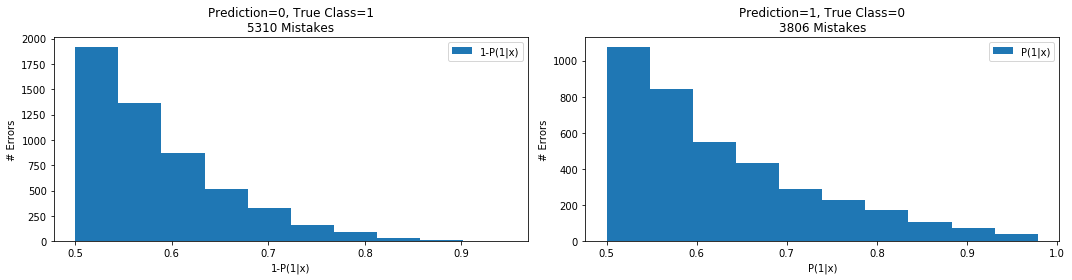

In [183]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(121)

filt = qs.loc[qs['prediction']==0,'P(1|x)']
ax.hist(1-filt, label='1-P(1|x)')
ax.set_title("Prediction=0, True Class=1\n{:d} Mistakes".format(len(filt)))
ax.set_xlabel("1-P(1|x)")
ax.set_ylabel("# Errors")
ax.legend()

ax = fig.add_subplot(122)
ax.hist(qs.loc[qs['prediction']==1,'P(1|x)'], label='P(1|x)')
ax.set_title("Prediction=1, True Class=0\n{:d} Mistakes".format(len(qs)-len(filt)))
ax.set_xlabel("P(1|x)")
ax.set_ylabel("# Errors")
ax.legend()

plt.tight_layout()
plt.show()

# TFIDF